In [1]:
import pandas as pd
import re
import numpy as np

In [443]:
from collections import defaultdict, Counter

In [444]:
import pickle

In [445]:
import pymorphy2

morph = pymorphy2.MorphAnalyzer()

In [522]:
def open_file(name):
    with open(name, 'rb') as f:
        book_storage = pickle.load(f)
    return book_storage

In [ ]:
book_storage = open_file('book_storage.pickle')
public_area = open_file('public_area.pickle')
area_surface = open_file('area_surface.pickle')
geners = open_file('book_geners.pickle')
servise_area = open_file('servise_area.pickle')

In [523]:
# В зоне обслуживания

In [453]:
nvis = pd.read_csv("number_visits.tsv", sep="\t")
data = pd.read_csv("база данных.csv", sep=",")
new = pd.read_csv("new_info.tcv", sep="\t")

In [454]:
new['year'] = new['Дата открытия'].str.extract('(\d{4})')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning:

currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)



In [455]:
nvis = nvis.fillna('')
new = new.fillna('')
data = data.fillna('')

In [456]:
nvis = nvis[:-1]

In [457]:
nvis.shape

(9546, 4)

In [458]:
set(nvis.prep)

{'', 'в', 'за', 'на', 'около', 'от', 'с', 'свыше'}

Алгоритм: 
    
    1) смотрим на кол-во посещений, если это число есть в кол-ве читателей, убираем его
    2) Из оставшихся значений делаем мин и макс значение кол-ва читателей, если есть указано сразу несколько

# Посетителей в месяц

### в n году/ за n год

In [459]:
a = nvis['n_days'].loc[nvis['prep'].isin(["в", "за"]) & (nvis['year'] != "")].index
nvis['n_days'].loc[a] = [365] * len(a)

### на n год

In [460]:
ind = nvis.loc[(nvis['prep'] == "на") & (nvis['year'] != "")].index
ind = set(ind)

In [461]:
ind2 = set(new.loc[new['year'] != ''].index)

In [462]:
comb = ind2 & ind

In [463]:
a = nvis['year'].loc[comb].apply(int)
b = new['year'].loc[comb].apply(int)

res = a - b

In [464]:
nvis['n_days'].loc[comb] = res * 365

### с n года

In [465]:
ind = nvis.loc[(nvis['prep'] == "с") & (nvis['year'] != "")].index
res = 2019 - nvis['year'].loc[ind].apply(int)
nvis['n_days'].loc[ind] = res * 365

In [466]:
a = nvis.loc[(nvis['n_days'].apply(type) != int) & (nvis['n_days'] != "")]
nvis['n_days'].loc[a.index] = a['n_days'].apply(int)

In [468]:
df = nvis[nvis['n_visits'].str.contains("_")]

In [469]:
df2 = nvis[nvis['n_visits'].str.contains(",")]

In [470]:
ind = set(df2.index) - set(df.index)
nvis['n_visits'].loc[ind] += '_1000'

In [471]:
nvis['n_visits'] = nvis.n_visits.str.replace(' ', '')
nvis['n_visits'] = nvis.n_visits.str.replace(',', '.')

In [472]:
df = nvis[nvis['n_visits'].str.contains("_")]

In [473]:
nvis['n_visits'].loc[ind]

3210    4.5_1000
Name: n_visits, dtype: object

In [474]:
str_num = {'полтора':1.5,
              'два':2,
              'три':3,
              'четыре':4,
              'пять':5,
              'шесть':6,
              'семь':7,
              'восемь':8,
              'девять':9,
              'десять':10,
             }

def str_to_num(x):
    
    global str_num
    
    p = morph.parse(x)[0]
    return str_num.get(p.normal_form)



In [475]:
for index in df.index:
    
    number, z = df.loc[index].n_visits.split('_')
    z = int(z)
    
    if '.' in number:
        n = float(number)
        nvis['n_visits'][index] = n * z
        
    elif number.isalpha():
        n = str_to_num(number)
        nvis['n_visits'][index] = n * z
    
    else:
        n = int(number)
        if n/z > 1: nvis['n_visits'][index] = n
        else: nvis['n_visits'][index] = n * z

In [476]:
a = np.where((nvis['n_visits'].apply(type) == str) & (nvis['n_visits'] != ''))
nvis['n_visits'].loc[a] = nvis['n_visits'].loc[a].apply(int)

In [477]:
nvis['nvis/month'] = [0]* nvis.shape[0]

In [478]:
a = np.where((nvis['n_visits'].apply(type) == int) & (nvis['n_days'].apply(type) == int))
b = nvis.loc[a]

nvis['nvis/month'].loc[a] = (b['n_visits'] / b['n_days']) * 30

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [479]:
def convert_str_to_int(v):
    
    if ',' in v and '_' not in v: v += '_1000'
                
    v = re.sub(',', '.', v)
    v = re.sub(' ', '', v)

    if '_' in v:
                    
        number, z = v.split('_')
        z = int(z)
    
        if '.' in number:
            n = float(number)
            v = n * z
        
        elif number.isalpha():
            n = str_to_num(number)
            v = n * z

        else:
            n = int(number)
            if n/z > 1: v = n
            else: v = n * z
    
    elif '.' in v: v = float(v)    
    else: v = int(v)        
    return v


In [480]:

res = {}

for i in n_readers:
    
    nv = nvis.loc[int(i)]['n_visits']
    ans = []

    for value in n_readers[i]:
        
        if '-' in value:
            vals = value.split('-')
        else: vals = [value]
            
        for v in vals:
            v = convert_str_to_int(v)
            if v > 10 and nv != v: 
                ans.append(v)

        if len(ans) > 1:
            res[i] = [max(ans), sum(ans)]
        elif len(ans) == 1: 
            res[i] = [ans[0], ans[0]]
       
 

In [481]:
max_nr = [None] * nvis.shape[0]
min_nr = [None] * nvis.shape[0]

for index in res:
    min_nr[index] = res[index][0]
    max_nr[index] = res[index][1]
    

In [ ]:
needed = ['газета', 'география', 'аудиовизуальный материал', 'другой иностранный язык',
          'детский', 'естествознание', 'журнал', 'кассета',
          'краеведение', 'крымскотатарский язык', 'литературоведение',
          'медицинский литература', 'методический', 'мусульманский',
          'отраслевой', 'периодика','подросток','редкий книга', 'чувашский язык',
          'русский язык', 'сельский хозяйство', 'спорт', 'справочный литература', 'татарский язык', 'техника',
          'художественный']

renamed = {'естественнонаучный': 'естествознание',
           'естественнонаучный литература': 'естествознание', 
           'естествознание': 'естествознание',
           'краеведение': 'краеведение',
           'краеведческий': 'краеведение', 
           'краеведческий издание': 'краеведение',
           'краеведческий литература': 'краеведение',
           'отраслевой': 'отраслевой', 'отраслевой и': 'отраслевой',
           'отраслевой литература': 'отраслевой', 
           'художественный': 'художественный',
           'художественный литература': 'художественный',
           'это художественный литература': 'художественный'
}



fond = {}
extradition = {}
res = {key:[None]*9546 for key in needed}


for index in range(0, 9546): #genres:
    
    inf = geners.get(index)
 
    if inf:
        for name in inf: #geners[index]:
 
            n = convert_str_to_int(geners[index][name])
            
            if 'фонд' in name:
                fond[index] = n
            elif 'выдача' in name:
                extradition[index] = n
            if 'детский' in name:
                res['детский'][index] = n
            else:
                gn = renamed.get(name)
                if gn: name = gn
    
                if name in needed:
                    res[name][index] = n



In [483]:
genres = pd.DataFrame(res)

# All together

In [484]:
nvis.shape, data.shape, new.shape

((9546, 5), (9546, 52), (9546, 8))

In [485]:
result = pd.concat([nvis, data, new, genres], axis=1)
#result = result.fillna('')

In [486]:
result.shape

(9546, 2960)

In [515]:
result['Max n_readers'] = max_nr
result['Min n_readers'] = min_nr

In [516]:
result.keys()

Index([      'n_visits',           'prep',         'n_days',           'year',
           'nvis/month',       'Название', 'Местоположение',   'Часовой пояс',
                'Улица',     'Примечание',
       ...
                   9536,             9537,             9540,             9542,
                   9544,  'Max n_readers',  'Min n_readers',   'Library type',
                  'lon',            'lat'],
      dtype='object', length=2965)

In [489]:
result.head()

,n_visits,prep,n_days,year,nvis/month,Название,Местоположение,Часовой пояс,Улица,Примечание,...,9532,9533,9535,9536,9537,9540,9542,9544,Max n_readers,Min n_readers
0,,,,,0,Аксёновская сельская библиотека-филиал № 4,Галичский район,Europe/Moscow,"д. Аксёново, 24",,...,700.0,4732.0,7056.0,7000.0,2000.0,500.0,1000.0,500.0,91.0,91.0
1,,,,,0,Мелёшинская сельская библиотека-филиал № 15,Галичский район,Europe/Moscow,"д. Мелёшино, ул. Центральная, 16",,...,700.0,4732.0,7056.0,7000.0,2000.0,500.0,1000.0,500.0,NaN,NaN
2,,,,,0,Ряжская центральная библиотека,Ряжский район,Europe/Moscow,"г. Ряжск, пл. Советская, 11",,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,,,,,0,Левковская сельская библиотека-филиал № 12,Галичский район,Europe/Moscow,"д. Левково, ул. Молодёжная, 1",,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.0,70.0
4,,,,,0,Сасовская центральная библиотека,Сасово,Europe/Moscow,"ул. Ленина, 40",,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Analysis


* Зависимость фонда от площади
* Типы библиотек по размеру фонда
* Население - площадь библиотеки
* Население - Размер фонда


Классификация по размеру фонда

* I (крупнейшие) - свыше 5000 тыс.единиц хранения,  
* П (крупные) - от 1000 до 5000 тыс. единиц хранения,
* Ш (средние) - от 200 до 1000 тыс. единиц хранения,
* IV (небольшие) - от 50 до 200 тыс. единиц хранения,
* V (малые) - от 5 до 50 тыс. единиц хранения.

In [490]:
result['Размер фонда'] = result['Размер фонда'].replace([''], ['0'], inplace=False)
result['Размер фонда'] = result['Размер фонда'].apply(int)#< 50000

In [399]:
#result['Library type'] = np.nan

In [408]:
#result['Library type'][0] = 'малые'
#ans = np.zeros(9546)

In [491]:
ans = [None]*9546

In [492]:
def fillin(val1, val2, vec, name):
    ind = result.loc[(result['Размер фонда'] < val1) & (result['Размер фонда'] > val2)].index
    #vec[ind] = name
    for i in ind: ans[i] = name

In [493]:
ind = result.loc[(result['Размер фонда'] < 50000) & (result['Размер фонда'] != 0)].index
#ans[ind] = ['малые']
for i in ind: ans[i] = 'малые'

In [494]:
val1, val2 = 50000, 50000
names = ['небольшие', 'средние', 'крупные']

for ind, i in enumerate([4, 5, 5]):
    val2 = val1
    val1 = val1*i
    fillin(val1, val2, ans, names[ind])

In [495]:
ind = result.loc[result['Размер фонда'] > 5000000].index
#ans[ind] = 'крупнейшие'
for i in ind: ans[i] = 'крупнейшие'

In [496]:
result['Library type'] = ans

In [429]:
import matplotlib.pyplot as plt

In [502]:
a = Counter(ans)
del a[None]

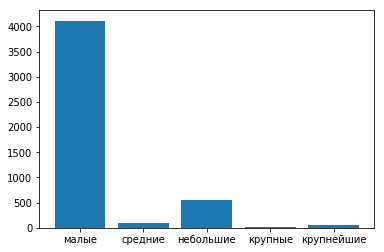

In [503]:
plt.bar(a.keys(), a.values())
plt.show()

In [227]:
import json 
import plotly.express as px

In [504]:
result['lon'] = [json.loads(i)['coordinates'][0] for i in result['На карте']]
result['lat'] = [json.loads(i)['coordinates'][1] for i in result['На карте']]

In [511]:
data = result.dropna(subset=['Library type'])
set(data['Library type'])

{'крупнейшие', 'крупные', 'малые', 'небольшие', 'средние'}

In [521]:
fig = px.scatter_mapbox(data, lat="lat", lon="lon", hover_name="Library type",
                        hover_data=["Название", "Местоположение"],
                        color=data['Library type'],
                        zoom=3, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Площадь

* 1k единиц хранения - 2,5 кв м

In [75]:
import math

def roundup(x):
    if isinstance(x, str):
        if x == '': return False
        elif '.' in x: x = float(x)
        else: x = int(x)
    return int(math.ceil(x / 1000.0)) * 1000



In [83]:
ans = []

for index in book_storage:
    fond = roundup(result.loc[index]['Размер фонда'])
    if fond:
        area = round(book_storage[index][0])
        must = (fond / 1000) * 2.5
        if area - must > 0:
            ans.append(1) 
        else: ans.append(0) 
        print(index, fond, area, must)
    

412 13000 49 32.5
880 29000 74 72.5
2579 9000 26 22.5
2588 7000 14 17.5
3489 13000 40 32.5
3691 12000 24 30.0
3961 6000 30 15.0
4153 16000 54 40.0
5059 29000 212 72.5


Число читательских мест в массовых библиотеках не должно превышать 0,8 читательского места на 1000 ед. хранения объема фонда библиотеки

In [82]:
13.0 * 2.5

32.5

"Читальные залы следует проектировать вместимостью не более чем 100 читательских мест"

In [ ]:
1 место - 2,4 м2

In [ ]:
ideal = 240

In [84]:
public_area

{145: [70],
 412: [17.6],
 656: [13],
 869: [56.4],
 1078: [127],
 1203: [12],
 2588: [70],
 3319: [20],
 3483: [28],
 3485: [97],
 3488: [30.4],
 3489: [30.0],
 3691: [25],
 3815: [114],
 3956: [38],
 3961: [10],
 3962: [99],
 3963: [30.0],
 3964: [36.7],
 3965: [59.3],
 4149: [39.5],
 4150: [32],
 4153: [17],
 4267: [73],
 5059: [221],
 5133: [352],
 7091: [56],
 8409: [45]}